In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
# import Kmeans from sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage
from sklearn.cluster import DBSCAN
from scipy.stats import wasserstein_distance, binned_statistic

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *
from use_cases import *

/Users/eylai/anaconda3/envs/lucid/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eylai/anaconda3/envs/lucid/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


(CVXPY) Oct 09 03:26:46 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 09 03:26:46 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [104]:
raw_data = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
dataset = 'pima'
min_num_bins = 2
max_num_bins = 20
target = 'Outcome'
gpt_measure = False
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
attributes = {'Age': [-1, 18, 35, 50, 65, 100], 'Glucose': [-1, 140, 200], 'BMI': [-1, 18.5, 25, 30, 68], }

for attr, gold_standard_bins in attributes.items():
    
    #ss = get_data_imputation_search_space(raw_data, attr, target, gold_standard_bins, min_num_bins, max_num_bins, gpt_measure)
    ss = get_explainable_modeling_search_space(raw_data, attr, target, gold_standard_bins, min_num_bins, max_num_bins, gpt_measure)
    break

Partition([20.0, 51.0, 81.0], [Bucket(21, 51.0, 695, None), Bucket(52, 81.0, 73, None)], equal-width, 8.809879996192493, 142.72701215957684)
Partition([20.0, 29.0, 81.0], [Bucket(21, 29.0, 396, None), Bucket(30, 81.0, 372, None)], equal-frequency, 3.192547360185763, 139.29465172791095)
Partition([20.0, 30.0, 82.0], [Bucket(21, 30.0, 417, None), Bucket(31, 82.0, 351, None)], chi-merge, 3.072342211236952, 139.71041478715895)
Partition([20.0, 51.0, 81.0], [Bucket(21, 51.0, 695, None), Bucket(52, 81.0, 73, None)], kbins, 8.809879996192493, 142.72701215957684)
Partition([20.0, 29.0, 81.0], [Bucket(21, 29.0, 396, None), Bucket(30, 81.0, 372, None)], kbins-quantile, 3.192547360185763, 139.29465172791095)
Partition([20.0, 28.5, 82.0], [Bucket(21, 28.5, 367, None), Bucket(29, 82.0, 401, None)], decision-tree, 3.495356417560969, 139.58957697478706)
Partition([20.0, 26.604127579737337, 82.0], [Bucket(21, 26.604127579737337, 300, None), Bucket(27, 82.0, 468, None)], kmeans, 4.545079341392118, 139.

In [133]:
def get_points(partitions, semantic_metric) -> List:
    if semantic_metric == 'l2_norm':
        semantics = [p.l2_norm for p in partitions]
    elif semantic_metric == 'gpt_distance':
        semantics = [p.gpt_distance for p in partitions]
    elif semantic_metric == 'KLDiv':
        semantics = [p.KLDiv for p in partitions]
    else: raise ValueError("Invalid semantic metric")
    utility = [p.utility for p in partitions]
    datapoints = [np.array(semantics), np.array(utility)]
    return datapoints

def linkage_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    #t = parameters['t']
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    Z = linkage(X, method='ward')
    agg_clusters = fcluster(Z, t=int(len(search_space.candidates)/5), criterion='maxclust')
    #agg_clusters = fcluster(Z, t=0.5, criterion='distance')
    agg_clusters = [x-1 for x in agg_clusters] # 0-indexing
    return agg_clusters

def DBSCAN_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    model = DBSCAN(eps=0.005, min_samples=3, metric='precomputed')
    dbscan_clusters = model.fit_predict(X)
    return dbscan_clusters

def HDBSCAN_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    model = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2)
    hdbscan_clusters = model.fit_predict(X)
    return hdbscan_clusters

def cluster_sampling(search_space, num_samples:int=2, frac_outlier_samples=0.5, semantic_metric='l2_norm', n_components=5, n_points_per_cluster=2) -> List:

    pca = PCA(n_components=2)
    X = np.array([p.binned_values for p in search_space.candidates])
    processed = pca.fit_transform(X)
    pcadf = pd.DataFrame( data = processed, columns = ['PC1', 'PC2'])

    cluster_assignments = linkage_distributions(search_space, {'n_components': n_components})
    #cluster_assignments = HDBSCAN_distributions(search_space, {'n_components': n_components})
    #cluster_assignments = HDBSCAN_binned_values(search_space, {'n_components': n_components})
    # plot a histogram of the clusters
    plt.hist(cluster_assignments, bins=len(np.unique(cluster_assignments)))
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Number of points', fontsize=14)
    print("Number of clusters:", len(np.unique(cluster_assignments)))

    outliers = [0 if c == -1 else 1 for c in cluster_assignments]

    # Get indices of -1 cluster
    outlier_indices = np.where(cluster_assignments == -1)[0]
    outliers = [search_space.candidates[i] for i in outlier_indices]
    outlier_points = get_points(outliers, semantic_metric)
    outlier_indices = np.random.choice(outlier_indices, int(len(outlier_indices) * frac_outlier_samples), replace=False)

    sampled_indices = []
    if num_samples == 1:
        for c in np.unique(cluster_assignments):
            if c == -1: sampled_indices.extend(outlier_indices)
            cluster_indices = np.where(cluster_assignments == c)[0]
            # Sample two partition from the cluster
            sampled_indices.extend(np.random.choice(cluster_indices, num_samples, replace=False))
    
    else:
        # Add gold standard partition to the sampled partitions
        #if 0 not in sampled_indices:
        #    sampled_indices.append(0)
        budget = num_samples * len(np.unique(cluster_assignments))
        # get cluster probabilities
        cluster_probs = np.bincount(cluster_assignments) / len(cluster_assignments)
        # get number of samples per cluster, with at least one sample per cluster
        cluster_samples = np.maximum(np.round(cluster_probs * budget).astype(int), 1)
        # sample from each cluster based on the number of samples
        for c in np.unique(cluster_assignments):
            if c == -1: sampled_indices.extend(outlier_indices)
            cluster_indices = np.where(cluster_assignments == c)[0]
            sampled_indices.extend(np.random.choice(cluster_indices, cluster_samples[c], replace=False))

    # Add gold standard partition to the sampled partitions
    if 0 not in sampled_indices:
        sampled_indices.append(0)
    sampled_partitions = [search_space.candidates[i] for i in sampled_indices]
    print("Sampled partition:", sampled_partitions[-1])
    explored_points, pareto_points, _ = get_pareto_front(sampled_partitions, semantic_metric)
    
    return explored_points, pareto_points, outlier_points, cluster_assignments


Datapoint shape to compute Pareto points: (2, 146)
Pareto points: [[1.0, 0.7662337662337663], [0.5836163960913718, 0.7987012987012987], [0.5836163960913718, 0.7987012987012987], [0.8792808497162352, 0.7922077922077922]]
Number of clusters: 29
Sampled partition: Partition([-1, 18, 35, 50, 65, 100], [Bucket(21, 18, 0, None), Bucket(21, 35, 498, None), Bucket(36, 50, 189, None), Bucket(51, 65, 68, None), Bucket(66, 100, 13, None)], gold-standard, 1.0, 1.0)
Datapoint shape to compute Pareto points: (2, 30)
Pareto points: [[0.5362654423256463, 0.7792207792207793], [0.5962415792442866, 0.7727272727272727], [0.473433143238594, 0.7987012987012987], [1.0, 0.7662337662337663]]


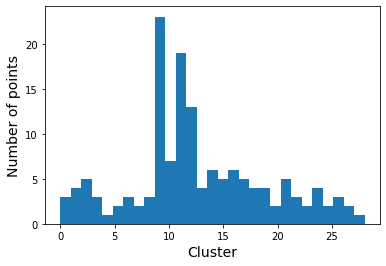

In [134]:
#for semantic_metric in semantic_metrics:
semantic_metric = 'l2_norm'
dim = 10
n_points_per_cluster = 2
n_samples = 1
datapoints, gt_pareto_points, points_df = get_pareto_front(ss.candidates, semantic_metric)
explored_points, est_pareto_points, outliers, clusters = cluster_sampling(ss, n_samples, 1, semantic_metric, dim, n_points_per_cluster)

In [135]:
points_df['Cluster'] = clusters
# for each cluster, calculate the count of each cluster, and mean and std of utility and semantic metric
#cluster_stats = points_df.groupby('Cluster').agg({'Utility': ['mean', 'std'], "Semantic": ['mean', 'std']})
cluster_stats = points_df.groupby('Cluster').agg({'Utility': ['mean', 'std','count'], "Semantic": ['mean', 'std']})
# order by semantic mean
cluster_stats = cluster_stats.sort_values(('Semantic', 'mean'))
print(cluster_stats)

          Utility                  Semantic          
             mean       std count      mean       std
Cluster                                              
9        0.775551  0.026328    23  0.133837  0.070549
11       0.767259  0.019026    19  0.192529  0.059672
10       0.769944  0.027257     7  0.270812  0.028409
15       0.788312  0.003557     5  0.294108  0.020050
12       0.731768  0.033885    13  0.310022  0.036623
16       0.769481  0.030938     6  0.375326  0.024034
13       0.774351  0.024512     4  0.394904  0.024793
19       0.745130  0.033689     4  0.412173  0.051261
14       0.756494  0.023141     6  0.428728  0.035230
20       0.759740  0.000000     2  0.429462  0.000000
18       0.750000  0.026243     4  0.429902  0.014109
21       0.754545  0.030595     5  0.442482  0.000731
25       0.746753  0.000000     2  0.481383  0.000000
28       0.766234       NaN     1  0.485645       NaN
27       0.737013  0.004592     2  0.498015  0.000422
26       0.738095  0.003749 

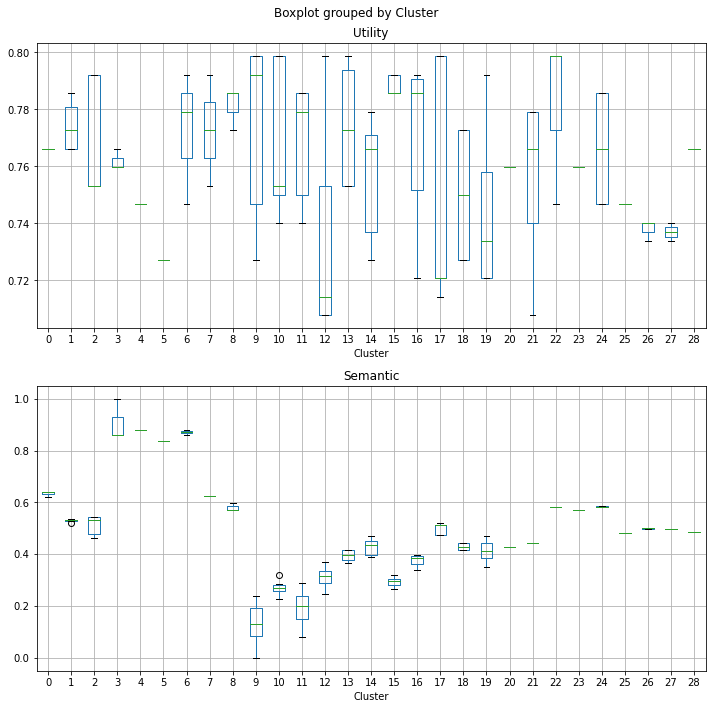

In [136]:
# plot box plots of utility and semantic metric for each cluster
fig, axs = plt.subplots(2,1, figsize=(10,10))
points_df.boxplot(column=['Utility'], by='Cluster', ax=axs[0])
points_df.boxplot(column=['Semantic'], by='Cluster', ax=axs[1])
plt.tight_layout()
# change two subplots to on top of each other
plt.show()

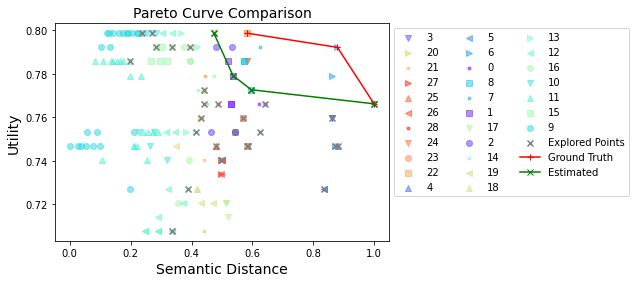

In [138]:
# plot scatter plot of utility and semantic metric for each cluster
import matplotlib.cm as cm
def plot_pareto_points(pareto_points:List, est_pareto_points:List, explored_points:List=None, points_df=None) -> Tuple:
    """
    Plot the estimated and ground truth Pareto fronts.
    Args:
        pareto_points (List): Ground truth Pareto front
        est_pareto_points (List): Estimated Pareto front
    """
    # Sort the points for plotting
    pareto_points = sorted(pareto_points, key=lambda x: x[0])
    est_pareto_points = sorted(est_pareto_points, key=lambda x: x[0])
    # Plot the Pareto front
    pareto_points = np.array(pareto_points)
    est_pareto_points = np.array(est_pareto_points)
    #datapoints = np.array(datapoints)
    # Set size of the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    #f, ax = plt.subplots()
    #ax.scatter(datapoints[0], datapoints[1], c='gray', label='Data Points', alpha=0.3)
    markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
    colors = cm.rainbow(np.linspace(0, 1, len(points_df['Cluster'].unique())))
    for cluster in points_df['Cluster'].unique():
        cluster_points = points_df[points_df['Cluster'] == cluster]
        marker_index = int(cluster % len(markers))
        ax.scatter(cluster_points['Semantic'], cluster_points['Utility'], label=cluster, color=colors[cluster], alpha=0.5, marker=markers[marker_index])

    ax.scatter(explored_points[0], explored_points[1], c='gray', label='Explored Points', marker='x',)
    ax.plot(pareto_points[:, 0], pareto_points[:, 1], '+-', c='red', label='Ground Truth')
    ax.plot(est_pareto_points[:, 0], est_pareto_points[:, 1], 'x-', c='green', label='Estimated')
    ax.legend(bbox_to_anchor=(1, 1),ncol=3)
    ax.set_xlabel('Semantic Distance', fontsize=14)
    ax.set_ylabel('Utility', fontsize=14)
    ax.set_title('Pareto Curve Comparison', fontsize=14)
    return fig, ax

fig, ax = plot_pareto_points(gt_pareto_points, est_pareto_points, explored_points, points_df)
plt.show()

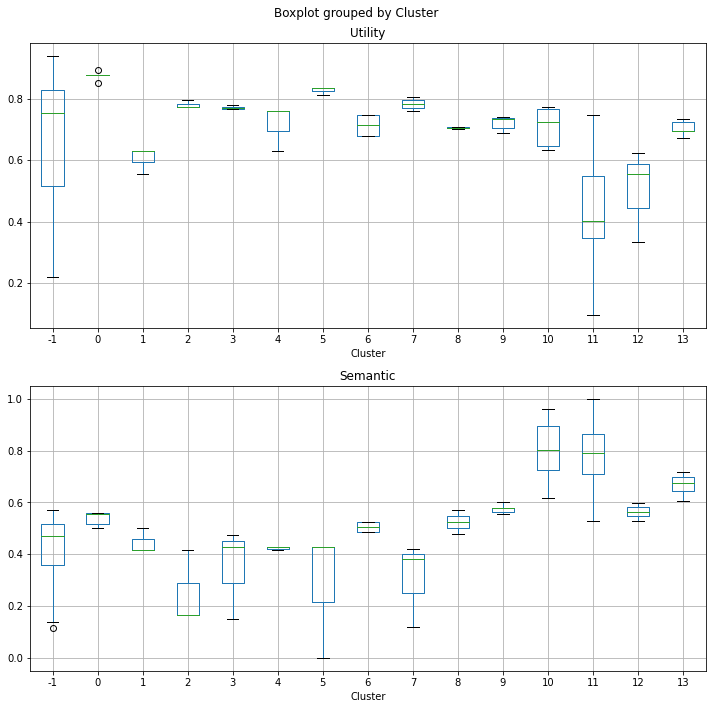

In [54]:
# plot box plots of utility and semantic metric for each cluster
fig, axs = plt.subplots(2,1, figsize=(10,10))
points_df.boxplot(column=['Utility'], by='Cluster', ax=axs[0])
points_df.boxplot(column=['Semantic'], by='Cluster', ax=axs[1])
plt.tight_layout()
# change two subplots to on top of each other
plt.show()

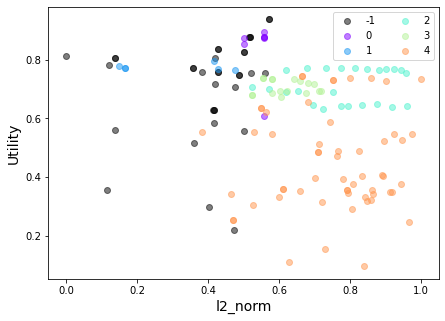

In [63]:
# plot scatter plot of utility and semantic metric for each cluster
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(7,5))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(clusters))))
for cluster in np.unique(clusters):
    cluster_points = points_df[points_df['Cluster'] == cluster]
    if cluster == -1:ax.scatter(cluster_points['Semantic'], cluster_points['Utility'], label=cluster, color='black', alpha=0.5)
    else: ax.scatter(cluster_points['Semantic'], cluster_points['Utility'], label=cluster, color=colors[cluster], alpha=0.5)
ax.legend(bbox_to_anchor=(1, 1),ncol=2)
plt.xlabel(semantic_metric, fontsize=14)
plt.ylabel('Utility', fontsize=14)
plt.show()

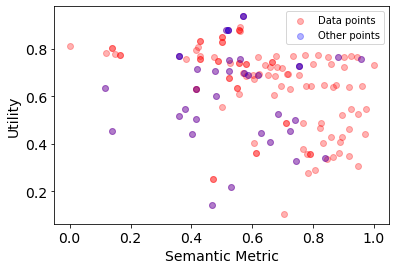

In [57]:
# top 3 biggest clusters
top_n = 1
cluster_sizes = np.unique(clusters, return_counts=True)
top_clusters = cluster_sizes[0][np.argsort(cluster_sizes[1])[-top_n:]]
top_cluster_indices = []
for c in top_clusters:
    top_cluster_indices.extend(np.where(clusters == c)[0])
top_cluster_points = [ss.candidates[i] for i in top_cluster_indices]
top_cluster_points = get_points(top_cluster_points, semantic_metric)

datapoints = np.array(datapoints)
otherpoints = np.array(top_cluster_points)
#print("Percentage of outliers:", len(outliers[0]) / len(datapoints[0]) * 100)
# Set size of the plot
f, ax = plt.subplots(figsize=(6, 4))
ax.scatter(datapoints[0], datapoints[1], c='red', label='Data points', alpha=0.3)
ax.scatter(otherpoints[0], otherpoints[1], c='blue', label='Other points', alpha=0.3)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Semantic Metric', fontsize=14)
ax.set_ylabel('Utility', fontsize=14)
ax.legend()
plt.show()

Percentage of outliers: 13.013698630136986


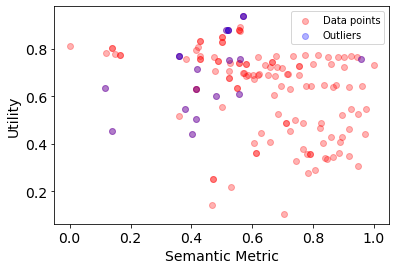

In [43]:
datapoints = np.array(datapoints)
outliers = np.array(outliers)
print("Percentage of outliers:", len(outliers[0]) / len(datapoints[0]) * 100)
# Set size of the plot
f, ax = plt.subplots(figsize=(6, 4))
ax.scatter(datapoints[0], datapoints[1], c='red', label='Data points', alpha=0.3)
ax.scatter(outliers[0], outliers[1], c='blue', label='Outliers', alpha=0.3)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Semantic Metric', fontsize=14)
ax.set_ylabel('Utility', fontsize=14)
ax.legend()
plt.show()

## Load experiment data

In [49]:
use_case = 'imputation'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_09_25_run1", use_case)
attributes = ['Age', 'Glucose', 'BMI']
data = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric'])
    data.append(df)
data = pd.concat(data)

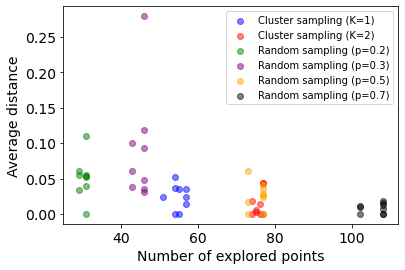

In [51]:
f, ax = plt.subplots(figsize=(6, 4))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
for i, method in enumerate(methods):
    ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[i], c = colors[i], alpha=0.5)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Number of explored points', fontsize=14)
ax.set_ylabel('Average distance', fontsize=14)
ax.legend()
plt.show()

In [10]:
# Make a dataframe, where each coloumn is a method and rows are means, stds of avg_dist and num_explored_points
results = pd.DataFrame()
for method in methods:
    results[method] = [data[data['method'] == method]['avg_dist'].mean(), data[data['method'] == method]['avg_dist'].std(), int(data[data['method'] == method]['num_explored_points'].mean())]
    # Round to 2 decimal places
    results[method] = results[method].apply(lambda x: round(x, 3))
results.index = ['mean_avg_dist', 'std_avg_dist', 'mean_num_explored_points']
results

,cluster_sampling_1_1,cluster_sampling_2_1,random_sampling_0.2,random_sampling_0.3,random_sampling_0.5,random_sampling_0.7
mean_avg_dist,0.025,0.014,0.051,0.089,0.026,0.008
std_avg_dist,0.018,0.018,0.029,0.078,0.019,0.007
mean_num_explored_points,54.000,75.000,30.000,45.000,75.000,106.000


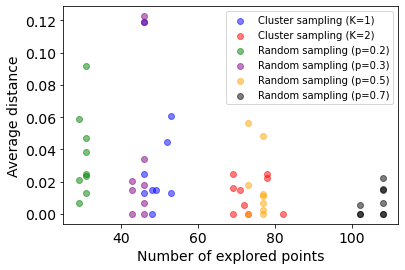

In [52]:
use_case = 'modelling'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_09_29_run1", use_case)
attributes = ['Age', 'Glucose', 'BMI']
data = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric'])
    data.append(df)
data = pd.concat(data)

f, ax = plt.subplots(figsize=(6, 4))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
for i, method in enumerate(methods):
    ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[i], c = colors[i], alpha=0.5)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Number of explored points', fontsize=14)
ax.set_ylabel('Average distance', fontsize=14)
ax.legend()
plt.show()

In [14]:
# Make a dataframe, where each coloumn is a method and rows are means, stds of avg_dist and num_explored_points
results = pd.DataFrame()
for method in methods:
    results[method] = [data[data['method'] == method]['avg_dist'].mean(), data[data['method'] == method]['avg_dist'].std(), int(data[data['method'] == method]['num_explored_points'].mean())]
    # Round to 2 decimal places
    results[method] = results[method].apply(lambda x: round(x, 3))
results.index = ['mean_avg_dist', 'std_avg_dist', 'mean_num_explored_points']
results

,cluster_sampling_1_1,cluster_sampling_2_1,random_sampling_0.2,random_sampling_0.3,random_sampling_0.5,random_sampling_0.7
mean_avg_dist,0.034,0.012,0.036,0.037,0.017,0.007
std_avg_dist,0.037,0.011,0.027,0.049,0.021,0.008
mean_num_explored_points,49.000,73.000,30.000,45.000,75.000,106.000


## Individual setup (per attribute-semantic)

In [139]:
use_case = 'imputation'
#dataset = 'pima'
#dst_folder = os.path.join(ppath, 'exp', f"pima.2024_10_10.linkage_distributions.run1", use_case)
#attributes = ['Age', 'Glucose', 'BMI']
dataset = 'titanic'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}.2024_10_11.linkage_distributions.run2", use_case)
attributes = ['Age', 'Fare']
dfs = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric', 'round'])
    dfs.append(df)
#data = pd.concat(data)

In [140]:
df['method'].unique()

array(['cluster_sampling_random', 'cluster_sampling_proportional',
       'cluster_sampling_reverse', 'random_sampling_0.2',
       'random_sampling_0.4', 'random_sampling_0.5',
       'random_sampling_0.7'], dtype=object)

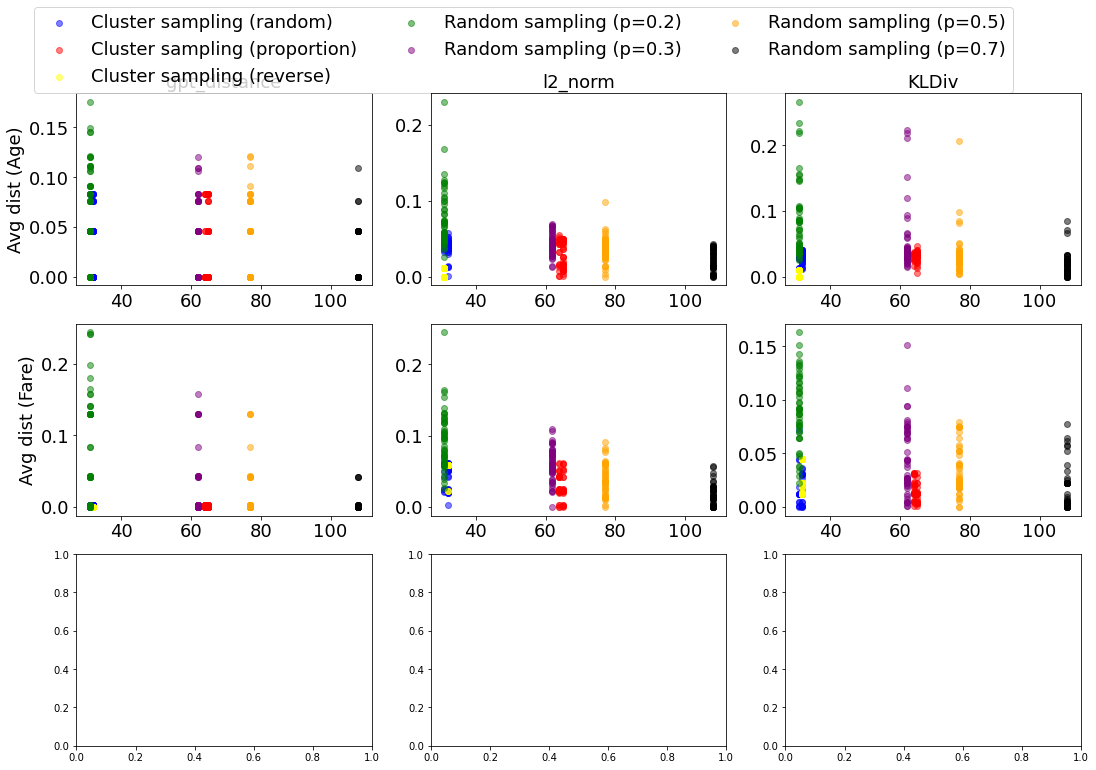

In [142]:

# Select rows with method ['cluster_sampling_1_3', 'cluster_sampling_2_3', 'random_sampling_0.2', 'random_sampling_0.3', 'random_sampling_0.5', 'random_sampling_0.7']
#df = dfs[0]
#methods = ['cluster_sampling_1_3', 'cluster_sampling_2_3', 'random_sampling_0.2', 'random_sampling_0.3', 'random_sampling_0.5', 'random_sampling_0.7']

#f, ax = plt.subplots(figsize=(6, 4))
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
method_names = ['Cluster sampling (random)', 'Cluster sampling (proportion)', 'Cluster sampling (reverse)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange', 'black']
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
font_size = 18

for k, df in enumerate(dfs):
    for i, semantic_metric in enumerate(semantic_metrics):
        data = df[df['semantic_metric'] == semantic_metric]
        #df = df[df['method'].isin(methods)]
        methods = data['method'].unique()
        ax = axs[k][i]
        for j, method in enumerate(methods):
            ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[j], c = colors[j], alpha=0.5)
        ax.xaxis.set_tick_params(labelsize=font_size)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if k == 2: ax.set_xlabel('Number of explored points', fontsize=font_size)
        if k == 0: ax.set_title(semantic_metric, fontsize=font_size)
        if i == 0: ax.set_ylabel(f'Avg dist ({attributes[k]})', fontsize=font_size)
        #if i == 2: ax.legend()
        if k==0 and i==0: ax.legend(ncol=3, fontsize=font_size, bbox_to_anchor=(3.2,1.5))
fig.tight_layout()
plt.show()

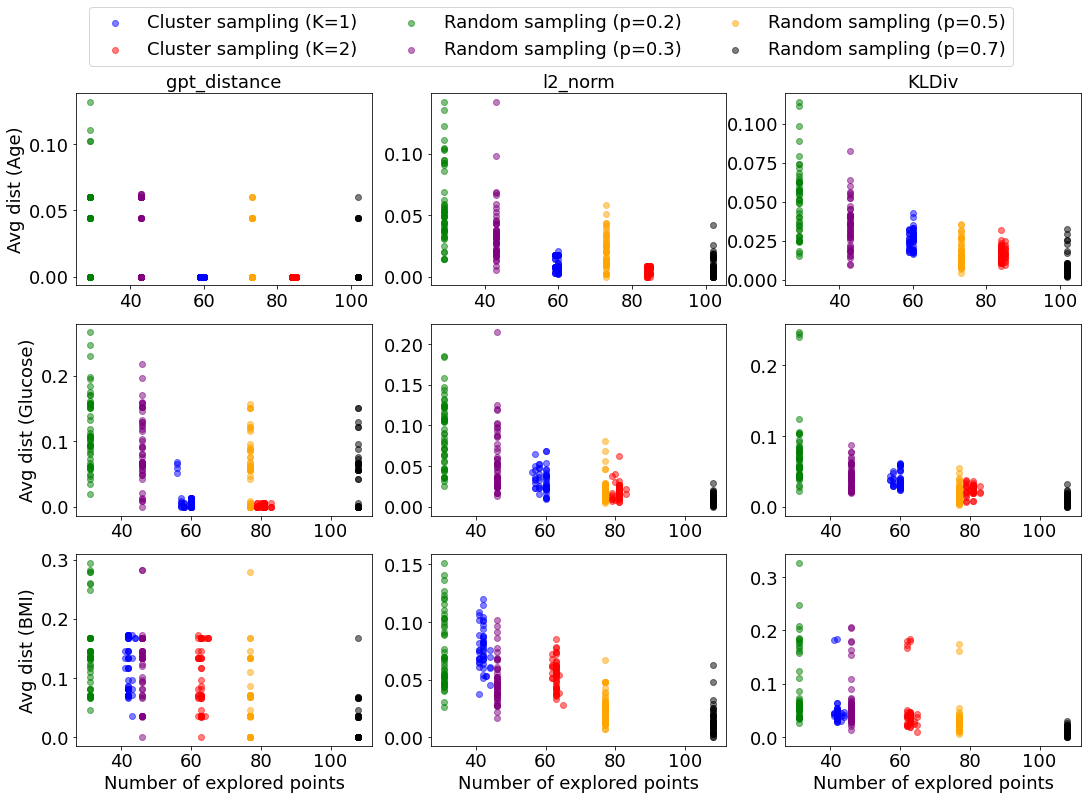

In [35]:
use_case = 'imputation'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_10_02_run2", use_case)
attributes = ['Age', 'Glucose', 'BMI']
dfs = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric', 'round'])
    dfs.append(df)
#data = pd.concat(data)

#f, ax = plt.subplots(figsize=(6, 4))
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
font_size = 18

for k, df in enumerate(dfs):
    for i, semantic_metric in enumerate(semantic_metrics):
        data = df[df['semantic_metric'] == semantic_metric]
        ax = axs[k][i]
        for j, method in enumerate(methods):
            ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[j], c = colors[j], alpha=0.5)
        ax.xaxis.set_tick_params(labelsize=font_size)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if k == 2: ax.set_xlabel('Number of explored points', fontsize=font_size)
        if k == 0: ax.set_title(semantic_metric, fontsize=font_size)
        if i == 0: ax.set_ylabel(f'Avg dist ({attributes[k]})', fontsize=font_size)
        #if i == 2: ax.legend()
        if k==0 and i==0: ax.legend(ncol=3, fontsize=font_size, bbox_to_anchor=(3.2,1.5))
fig.tight_layout()
plt.show()

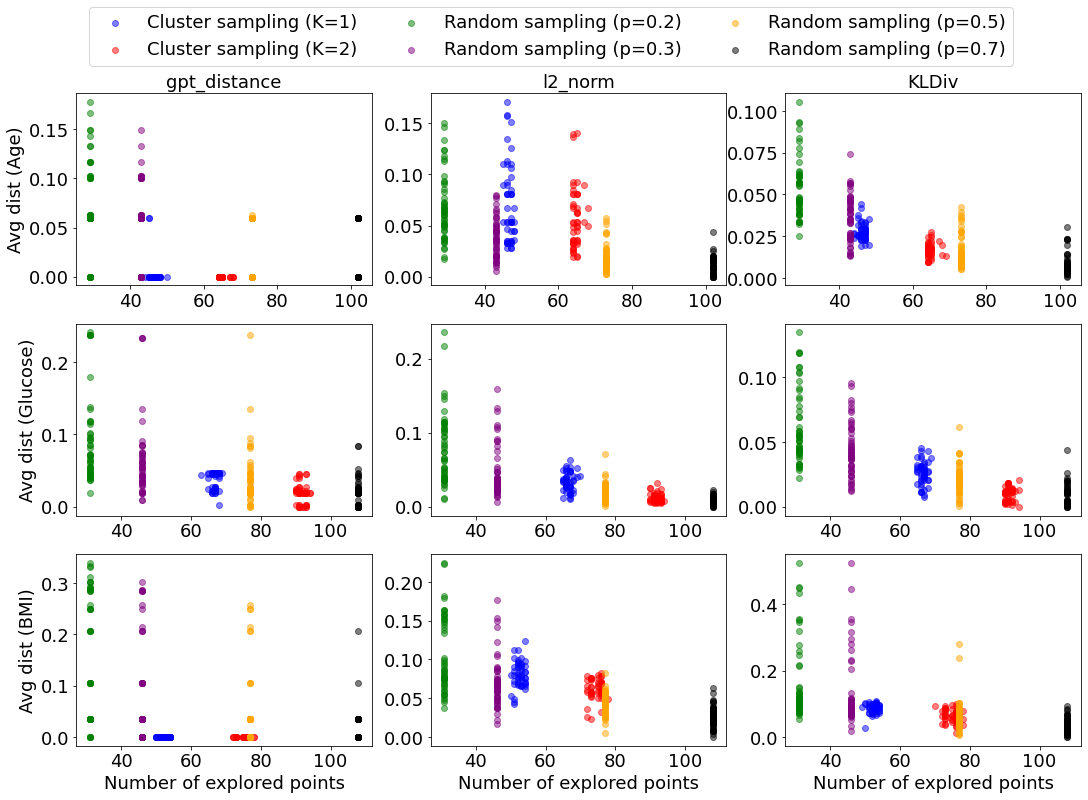

In [34]:
use_case = 'imputation'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_10_02_run3", use_case)
attributes = ['Age', 'Glucose', 'BMI']
dfs = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric', 'round'])
    dfs.append(df)
#data = pd.concat(data)

#f, ax = plt.subplots(figsize=(6, 4))
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
font_size = 18

for k, df in enumerate(dfs):
    for i, semantic_metric in enumerate(semantic_metrics):
        data = df[df['semantic_metric'] == semantic_metric]
        ax = axs[k][i]
        for j, method in enumerate(methods):
            ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[j], c = colors[j], alpha=0.5)
        ax.xaxis.set_tick_params(labelsize=font_size)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if k == 2: ax.set_xlabel('Number of explored points', fontsize=font_size)
        if k == 0: ax.set_title(semantic_metric, fontsize=font_size)
        if i == 0: ax.set_ylabel(f'Avg dist ({attributes[k]})', fontsize=font_size)
        #if i == 2: ax.legend()
        if k==0 and i==0: ax.legend(ncol=3, fontsize=font_size, bbox_to_anchor=(3.2,1.5))
fig.tight_layout()
plt.show()